In [189]:
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

from util import preprocess_util

DATA_FILE = './data/MI_Jake_00.xdf'

In [124]:
streams, header = pyxdf.load_xdf(DATA_FILE)

openvibe_stream = streams[0]
unicorn_stream = streams[1]
fs = 250

# Deal with the labels

In [88]:
def unique(input_list):
    unique_items = []
    for x in input_list:
        if x not in unique_items:
            unique_items.append(x)
    
    return unique_items

def build_unique_mapping(unique_labels):
    unique_mapping = {}
    for i, label in enumerate(unique_labels):
        unique_mapping[label] = i
    
    return unique_mapping

In [93]:
label_list = [x[0] for x in openvibe_stream['time_series']]
unique_items = unique(label_list)
unique_mapping = build_unique_mapping(unique_items)
print(unique_mapping)


event_codes = np.array([unique_mapping[x] for x in label_list])
event_codes

{'beep': 0, 'cue_no_blink': 1, 'imagery_no_blink': 2, 'break': 3, 'cue_handR': 4, 'imagery_handR': 5, 'cue_handL': 6, 'imagery_handL': 7}


array([0, 1, 2, 3, 4, 5, 3, 6, 7, 3, 6, 7, 3, 4, 5, 3, 4, 5, 3, 6, 7, 3,
       4, 5, 3, 6, 7, 3, 6, 7, 3, 4, 5, 3, 0, 6, 7, 3, 4, 5, 3, 6, 7, 3,
       4, 5, 3, 6, 7, 3, 4, 5, 3, 4, 5, 3, 6, 7, 3, 6, 7, 3, 4, 5, 3, 0,
       4, 5, 3, 6, 7, 3, 4, 5, 3, 6, 7, 3, 6, 7, 3, 4, 5, 3, 6, 7, 3, 4,
       5, 3, 6, 7, 3, 4, 5, 3, 0, 6, 7, 3, 4, 5, 3, 4, 5, 3, 6, 7, 3, 4,
       5, 3, 6, 7, 3, 6, 7, 3, 4, 5, 3, 6, 7, 3, 4, 5, 3, 0, 4, 5, 3, 6,
       7, 3, 4, 5, 3, 6, 7, 3, 4, 5, 3, 6, 7, 3, 6, 7, 3, 4, 5, 3, 6, 7,
       3, 4, 5, 3])

In [94]:
event_time_stamps = np.array(openvibe_stream['time_stamps'])

# Deal with the EEG data

In [45]:
# Extract the channels
unicorn_time_series = unicorn_stream['time_series'][:,0:8]

# Rereference
unicorn_time_series = unicorn_time_series - np.mean(unicorn_time_series, axis=0)

unicorn_time_series.shape

(174309, 8)

In [53]:
def normalise(time_series):
    _min = unicorn_time_series.min()
    _max = unicorn_time_series.max()

    return (time_series - _min) / (_max - _min)

# Normalise data
n_unicorn_time_series = normalise(unicorn_time_series)

print(n.min())
print(n.max())

0.0
1.0


# Timestamps

In [77]:
eeg_timestamps = unicorn_stream['time_stamps']
eeg_start_time = eeg_timestamps[0]
label_start_time = event_time_stamps[0]
experiment_start_time = min(label_start_time, eeg_start_time)

relative_eeg_timestamps = eeg_timestamps - experiment_start_time
relative_event_time_stamps = event_time_stamps - experiment_start_time

In [83]:
def find_closest_time(timestamp, eeg_timestamps):

    return np.where(eeg_timestamps > timestamp)[0][0]

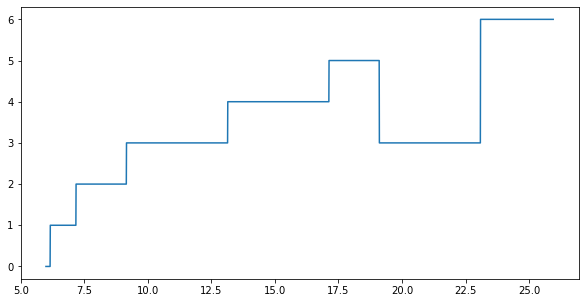

In [136]:
# Get indices of events
indices = [0]

for timestamp in relative_event_time_stamps:
    indices.append(find_closest_time(timestamp, relative_eeg_timestamps))

# Build event time series
event_time_series = np.zeros_like(eeg_timestamps) - 1

for i, (_, code) in enumerate(zip(indices[1:], event_codes)):
    event_time_series[indices[i]:indices[i+1]] = code


window = 20
start_time = 6
t = np.arange(0, window*fs, 1/fs)
plt.figure(figsize=(10,5))
plt.plot(relative_eeg_timestamps[start_time*fs:(start_time + window)*fs],
    event_time_series[start_time*fs:(start_time + window)*fs])

plt.show()

# Visualise

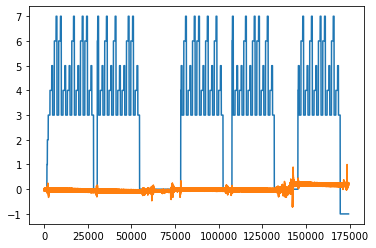

In [150]:
plt.plot(event_time_series)
plt.plot(unicorn_time_series[:,0]/unicorn_time_series[:,0].max())

# Filter the data

In [194]:
channel_number = 0
eeg_data = unicorn_time_series.T
eeg_single_channel = eeg_data[0,:]

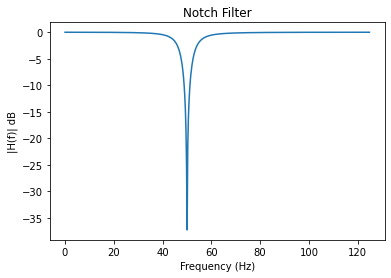

In [214]:
lf = 4
hf = 30
nf = 50

b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

plt.figure()
plt.plot( freq, 20*np.log10(abs(h)))
plt.title('Notch Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|H(f)| dB')
plt.show()


eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess_util.bandpass(samples_buffer=eeg_notched, lf=lf, hf=hf, fs=fs, ftype='iir')

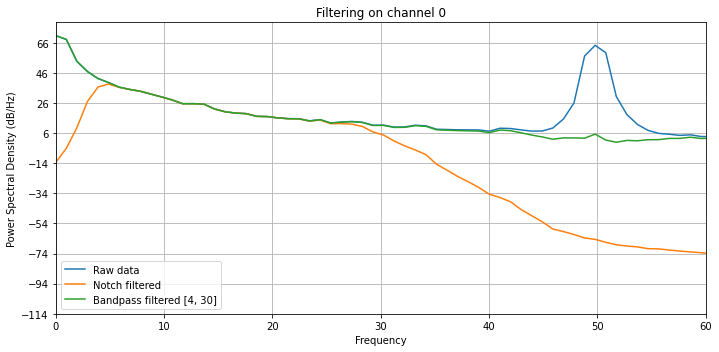

In [218]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on channel {channel_number}')
plt.psd(eeg_data[0], Fs=fs, label='Raw data')
plt.psd(eeg_notched_bp[0], Fs=fs, label='Notch filtered')
plt.psd(eeg_notched[0], Fs=fs, label=f'Bandpass filtered [{lf}, {hf}]')
plt.tight_layout()
plt.legend()
plt.xlim([0,60])
plt.show()

In [223]:
def channel_name_mapping(channel_number):
    mapping = {
        0:  'EEG Fz',    
        1:  'EEG C3', 
        2:  'EEG Cz', 
        3:  'EEG C4',
        4:  'EEG Pz', 
        5:  'EEG PO7', 
        6:  'EEG Oz', 
        7:  'EEG PO8',
    }
    return mapping[channel_number]

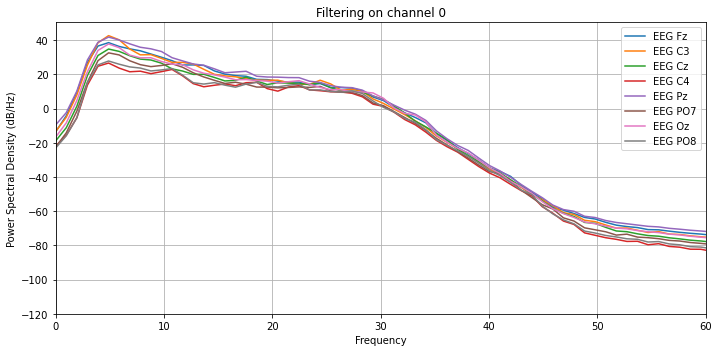

In [225]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on channel {channel_number}')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{channel_name_mapping(i)}')

plt.tight_layout()
plt.legend()
plt.xlim([0,60])
plt.show()

# Inspect Time Series

ipykernel_launcher:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


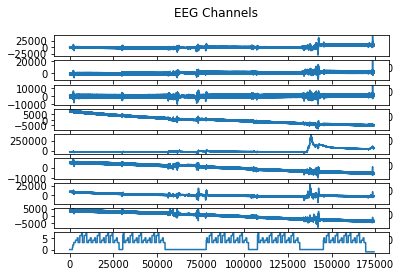

In [228]:
def plot_data(eeg_data, eeg_labels):
    fig, axs = plt.subplots(9)
    fig.suptitle('EEG Channels')
    for i in range(8):
        axs[i].plot(eeg_data[i])
    axs[8].plot(eeg_labels)


plot_data(eeg_data, event_time_series)

# Split into trials

# Normalise EEG data 